In [4]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

def load_audio_file(file_path, sr=22050):
    print("load_audio_file...")
    audio, sr = librosa.load(file_path, sr=sr, mono=True)
    return audio, sr

def audio_to_spectrogram(audio, n_fft=256, hop_length=128):
    print("audio_to_spectrogram")
    chunk_samples = int((n_fft/2 - 1)*hop_length + n_fft)
    num_chunks = int(np.ceil(len(audio) / chunk_samples))
    print(f"number of chunks: {num_chunks}")
    spectrograms = []
    for i in tqdm(range(num_chunks), desc='Processing audio chunks'):
        start = i*chunk_samples
        end = min((i + 1) * chunk_samples, len(audio))
        chunk = audio[start:end]
        if len(chunk) <= 100: #1초보다 짧으면..
            continue
        elif len(chunk) < chunk_samples:
            chunk = np.pad(chunk, (0, chunk_samples - len(chunk)), 'constant')  # 부족한 부분을 0으로 패딩'''
        # 스펙트로그램 계산
        audio_tf = tf.convert_to_tensor(chunk, dtype=tf.float32)
        S = tf.signal.stft(audio_tf, frame_length=n_fft, frame_step=hop_length)
        #print(f"dataSize{S.shape}")
        S_cropped = S[:128, :128]
        S_abs = tf.abs(S_cropped)
        if S_abs.numpy().size > 0:  # 비어 있지 않은 데이터만 처리
            S_db = librosa.amplitude_to_db(S_abs.numpy())
            spectrograms.append(S_db.T)
    print(".")
    return spectrograms

def save_spectrograms(spectrograms, output_dir, base_filename):
    # 지정된 디렉토리가 없을 경우 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")

    for i, spec in enumerate(spectrograms):
        np.save(os.path.join(output_dir, f"{base_filename}_chunk_{i}.npy"), spec)

def process_audio_files(folder_path, output_dir, start=0, end=10000):
    all_files = [os.path.join(root, file)
                 for root, dirs, files in os.walk(folder_path)
                 for file in files if file.endswith('.mp3') or file.endswith('.flac')]
    total_files = len(all_files)
    print(f"Total files to process: {total_files}")

    for index, file_path in enumerate(all_files):
        if index >= end: break
        if index < start: continue
        print(f"Processing file {index + 1} of {total_files}: {file_path}")
        base_filename = os.path.splitext(os.path.basename(file_path))[0]
        audio, sr = load_audio_file(file_path)
        spectrograms = audio_to_spectrogram(audio)
        save_spectrograms(spectrograms, output_dir, base_filename)

# 사용 예
input_folder = '/content/drive/My Drive/GANProject/GANpiano'
output_folder = '/content/spec_128_'
process_audio_files(input_folder, output_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total files to process: 1
Processing file 1 of 1: /content/drive/My Drive/GANProject/GANpiano/The Best Of Chopin.mp3
load_audio_file...
audio_to_spectrogram
number of chunks: 57287


Processing audio chunks: 100%|██████████| 57287/57287 [06:51<00:00, 139.17it/s]


.
Created directory: /content/spec_128_


In [23]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [36]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Layer, Input, Conv2D, Conv2DTranspose, Flatten, Dense, LeakyReLU, BatchNormalization, ReLU, Dropout, Activation, Reshape, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

print("GPU Available: ", tf.test.is_gpu_available())
print("Devices:", tf.config.list_physical_devices())

np.set_printoptions(linewidth=200)


GPU Available:  True
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def load_spectrogram(file_path):
    # EagerTensor에서 바로 numpy 배열로 변환 후 decode
    file_path = file_path.numpy().decode()
    spec = np.load(file_path)
    spec = np.expand_dims(spec, axis=-1)  # 채널 차원 추가
    factor = np.max(spec) - np.min(spec)
    if factor > 0:
        spec = 2 * (spec - np.min(spec)) / factor - 1  # -1과 1 사이로 정규화
    return spec

def preprocess(file_path):
    # TensorFlow ops에서 사용할 수 있도록 load_spectrogram을 wrapper 함수로 호출
    spectrogram = tf.py_function(load_spectrogram, [file_path], Tout=[tf.float32])
    spectrogram = spectrogram[0]
    return spectrogram

def create_dataset(data_dir, batch_size=32):
    # 파일 경로 로드
    file_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith('.npy')]
    print("file_paths")
    # TensorFlow Dataset 객체 생성
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    print("tensor_slice")
    # 파일 경로를 실제 데이터로 변환
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    print("dataset.map")
    # 배치 처리 및 prefetching
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    print("dataset.batch")
    # 데이터셋의 배치 형태를 확인하기 위한 코드
    return dataset

In [37]:
def build_generator(noise_shape):
    #input size: 100
    inputs = Input(shape=noise_shape)

    x = Dense(16*16*256)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Reshape((16, 16, 256))(x)
    #16*16*256
    # Upsampling
    x = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #32*32*128
    x = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #64*64*64
    x = Conv2DTranspose(1, kernel_size=5, strides=2, padding='same')(x)
    #128*128*1
    x = Activation('tanh')(x)

    return Model(inputs, x)

def build_discriminator(input_shape):
    #input size: 128*128
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=5, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    #x = Dropout(0.2)(x)
    #64*64*64
    x = Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    #x = Dropout(0.2)(x)
    x = RandomShuffleLayer()(x)
    #32*32*128
    '''
    x = Conv2D(256, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = RandomShuffleLayer()(x)
    '''
    x= Flatten()(x)
    x = Dense(1)(x)
    #x = Activation('sigmoid')(x)

    return Model(inputs, x)


class RandomShuffleLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RandomShuffleLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Assuming inputs are of shape [batch_size, height, width, channels]
        def shuffle_along_axis(image):
            # Shuffle along the width (axis=1)
            shuffled = tf.random.shuffle(tf.transpose(image, [1, 0, 2]))
            return tf.transpose(shuffled, [1, 0, 2])

        # Apply to each image in the batch
        outputs = tf.map_fn(shuffle_along_axis, inputs, dtype=tf.float32)
        return outputs


Instructions for updating:
Use fn_output_signature instead


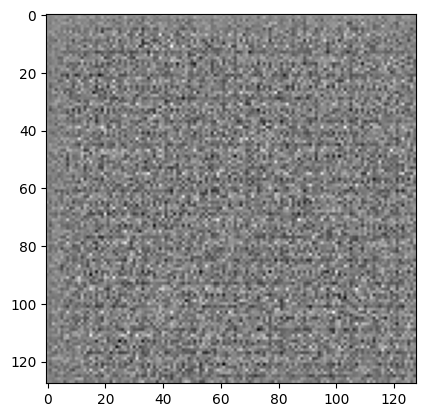

In [5]:
generator = build_generator((100,))
discriminator = build_discriminator((128,128,1))

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [38]:
def save_spectrogram(spectrogram, epoch, output_dir, X_mean=-5, X_std=45):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Convert EagerTensor to numpy if not already
    if isinstance(spectrogram, tf.Tensor):
        spectrogram = spectrogram.numpy()

    # Squeeze to remove single-dimensional entries from the shape
    spectrogram = spectrogram.squeeze()

    # Reversing the normalization formula to get the original log magnitude
    X_mag = (spectrogram * X_std) + X_mean
    np.save(os.path.join(output_dir, f'spectrogram_epoch_{epoch}.npy'), X_mag)

    # Configure the plot
    plt.figure(figsize=(10, 4))
    plt.imshow(X_mag, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram at Epoch {epoch}')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.tight_layout()

    # Save the figure
    plt.savefig(os.path.join(output_dir, f'spectrogram_epoch_{epoch}.png'))
    plt.close()


In [44]:

# 하이퍼파라미터
LAMBDA_GP = 10.0  # Gradient penalty coefficient

# 판별자 손실 함수
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    return fake_loss - real_loss

# 생성자 손실 함수
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

# 그라디언트 패널티 계산
@tf.function
def gradient_penalty(batch_size, real_images, fake_images, discriminator):
    alpha = tf.random.uniform([batch_size, 1, 1, 1], minval=0., maxval=1.)
    interpolated_images = real_images * alpha + fake_images * (1 - alpha)

    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        predictions = discriminator(interpolated_images)
    gradients = tape.gradient(predictions, [interpolated_images])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

# 훈련 스텝
@tf.function
def train_step(real_images, generator, discriminator, batch_size, noise_dim):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # Gradient penalty
        gp = gradient_penalty(batch_size, real_images, generated_images, discriminator)
        disc_loss += gp * LAMBDA_GP

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator.optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator.optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

# 모델과 옵티마이저 설정
def create_models():
    generator = build_generator([100])
    discriminator = build_discriminator([128, 128, 1])
    g_optimizer = Adam(2e-4, beta_1=0.5)
    d_optimizer = Adam(2e-4, beta_1=0.5)
    generator.optimizer = g_optimizer
    discriminator.optimizer = d_optimizer
    return generator, discriminator

# 훈련 루프
def train(generator, discriminator, dataset, epochs, batch_size, noise_dim, save_interval, output_dir):
    # 체크포인트 파일 경로 설정
    checkpoint_path_gen = os.path.join(output_dir, "generator_epoch_{epoch:04d}.ckpt")
    checkpoint_path_disc = os.path.join(output_dir, "discriminator_epoch_{epoch:04d}.ckpt")

    # 생성자와 판별자를 위한 ModelCheckpoint 콜백 생성
    checkpoint_callback_gen = ModelCheckpoint(
        filepath=checkpoint_path_gen,
        save_weights_only=True,
        save_freq=save_interval,  # save_interval 마다 저장
        verbose=1)

    checkpoint_callback_disc = ModelCheckpoint(
        filepath=checkpoint_path_disc,
        save_weights_only=True,
        save_freq=save_interval,  # save_interval 마다 저장
        verbose=1)

    # 훈련 루프
    for epoch in range(epochs):
        for batch_index, image_batch in enumerate(dataset):
            gen_loss, disc_loss = train_step(image_batch, generator, discriminator, batch_size, noise_dim)
            if (batch_index + 1) % 100 == 0:
                print(f'Epoch {epoch + 1}, Batch {batch_index + 1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}')

        # 각 에폭의 끝에서 체크포인트 저장
         # 각 에폭의 끝에서 이미지 생성 및 체크포인트 저장
        noise = tf.random.normal([batch_size, noise_dim])
        generated_images = generator(noise, training=False)  # 생성자를 사용하여 이미지 생성
        checkpoint_callback_gen.on_epoch_end(epoch, logs={'loss': gen_loss.numpy()})
        checkpoint_callback_disc.on_epoch_end(epoch, logs={'loss': disc_loss.numpy()})
        save_spectrogram(generated_images, epoch, output_dir)

In [45]:


# 경로 설정
data_dir = '/content/spec_128_'
output_dir = 'drive/MyDrive/GANProject/GAN_0607_2'

noise_dim = 100
input_shape = (128, 128, 1)

# 하이퍼파라미터 설정
epochs = 200
batch_size = 32
save_interval = 5

dataset = create_dataset(data_dir, batch_size)
generator, discriminator = create_models()

train(generator, discriminator, dataset, epochs, batch_size, noise_dim, save_interval, output_dir)



file_paths
tensor_slice
dataset.map
dataset.batch
Epoch 1, Batch 100, Gen Loss: nan, Disc Loss: nan
Epoch 1, Batch 200, Gen Loss: nan, Disc Loss: nan
Epoch 1, Batch 300, Gen Loss: nan, Disc Loss: nan
Epoch 1, Batch 400, Gen Loss: nan, Disc Loss: nan
Epoch 1, Batch 500, Gen Loss: nan, Disc Loss: nan
Epoch 1, Batch 600, Gen Loss: nan, Disc Loss: nan
Epoch 1, Batch 700, Gen Loss: nan, Disc Loss: nan
Epoch 1, Batch 800, Gen Loss: nan, Disc Loss: nan
Epoch 1, Batch 900, Gen Loss: nan, Disc Loss: nan
Epoch 1, Batch 1000, Gen Loss: nan, Disc Loss: nan
Epoch 1, Batch 1100, Gen Loss: nan, Disc Loss: nan


KeyboardInterrupt: 